# **Data Exploration Notebook**

## Objectives

* Explore the data
* Understand which attributes are most correlated to sale price

## Inputs

* Kaggle data file - inputs/datasets/raw/house-prices/house-price/house_prices_records.csv
* Kaggle data file - inputs/datasets/raw/house-prices/house-price/inherited_house.csv

---

# Change working directory

Accessing the current directory

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-heritage-housing-issues/jupyter_notebooks'

Making sure working in the child of the workspace directory

In [4]:
os.chdir('/workspaces/milestone-project-heritage-housing-issues')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspaces/milestone-project-heritage-housing-issues'

---

# Explore the Kaggle Data

* Load Kaggle Data

In [6]:
import pandas as pd
allowed_nans = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN',
                '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA',
                'NULL', 'NaN', 'n/a', 'nan', 'null']
df = pd.read_csv(f"inputs/datasets/raw/house-prices/house-price/house_prices_records.csv", na_values=allowed_nans, keep_default_na=False)
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


* Run Profile Report

In [7]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

## Correlation and PPS Analysis

* Change object type data to numerical data

In [8]:
df['BsmtExposure'] = df['BsmtExposure'].replace({'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
df['BsmtFinType1'] = df['BsmtFinType1'].replace({'None':0, 'Unf':1, 'LwQ':2, 'BLQ':3, 'Rec':4, 'ALQ':5, 'GLQ':6})
df['GarageFinish'] = df['GarageFinish'].replace({'None':0, 'Unf':1, 'RFn':2, 'Fin':3})
df['KitchenQual'] = df['KitchenQual'].replace({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

* Spearman Correlation

In [9]:
df_spearman = df.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head()
df_spearman

OverallQual    0.809829
GrLivArea      0.731310
KitchenQual    0.672849
YearBuilt      0.652682
GarageArea     0.649379
Name: SalePrice, dtype: float64

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap_corr(df, threshold, figsize, font_annot):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()

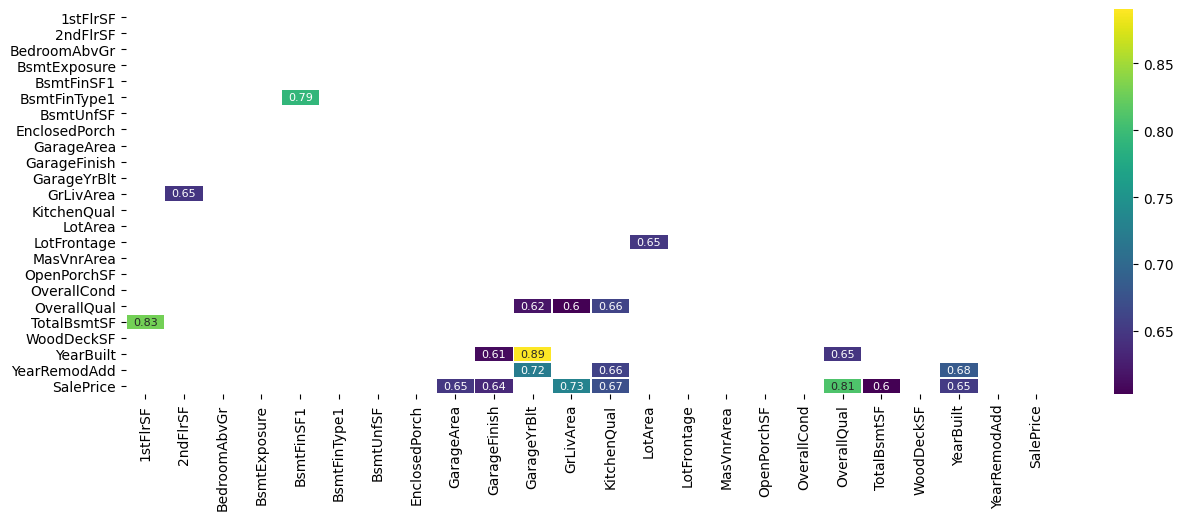

In [11]:
df_spearman_heat = df.corr(method='spearman')
heatmap_corr(df=df_spearman_heat, threshold=0.6, figsize=(15, 5), font_annot=8)

* Pearson Correlation

In [12]:
df_pearson = df.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head()
df_pearson

OverallQual    0.790982
GrLivArea      0.708624
KitchenQual    0.659600
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64

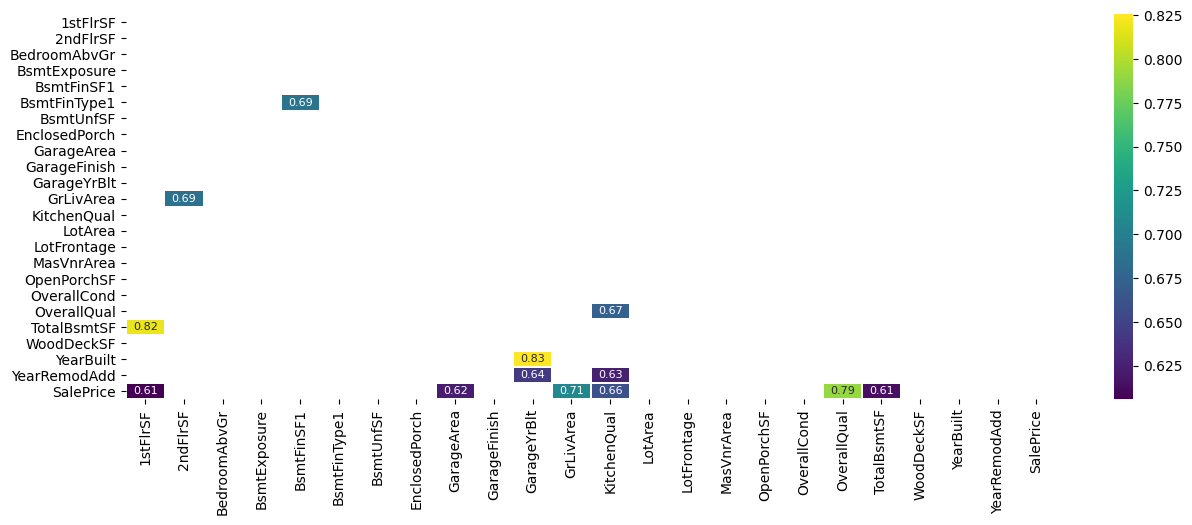

In [13]:
df_pearson_heat = df.corr(method='pearson')
heatmap_corr(df=df_pearson_heat, threshold=0.6, figsize=(15, 5), font_annot=8)

* Top five correlated attributes, to SalePrice

In [14]:
set(df_pearson[:4].index.to_list() + df_spearman[:4].index.to_list())

{'GarageArea', 'GrLivArea', 'KitchenQual', 'OverallQual', 'YearBuilt'}

Therefore I will investigate how the following attributes affect SalePrice:

* GarageArea
* GrLivArea
* KitchenQual
* OverallQual
* YearBuilt

In [15]:
vars_to_study = ['GarageArea', 'GrLivArea', 'KitchenQual', 'OverallQual', 'YearBuilt']
vars_to_study

['GarageArea', 'GrLivArea', 'KitchenQual', 'OverallQual', 'YearBuilt']

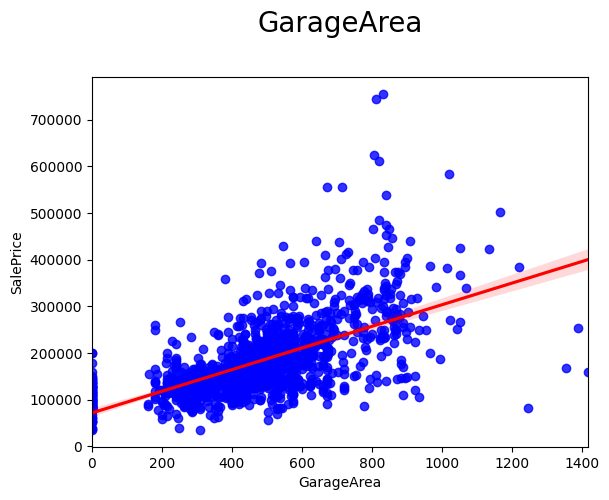

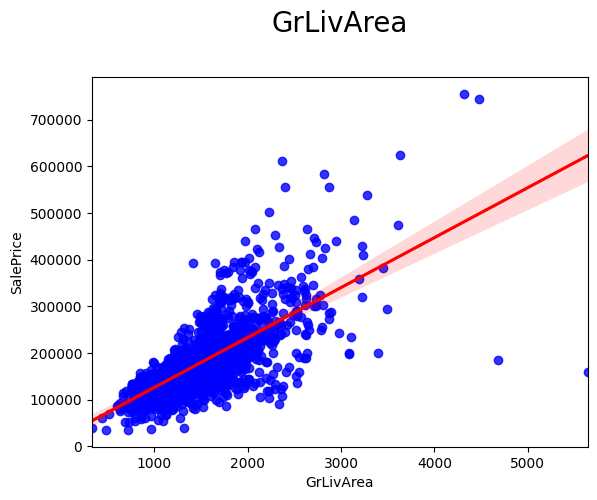

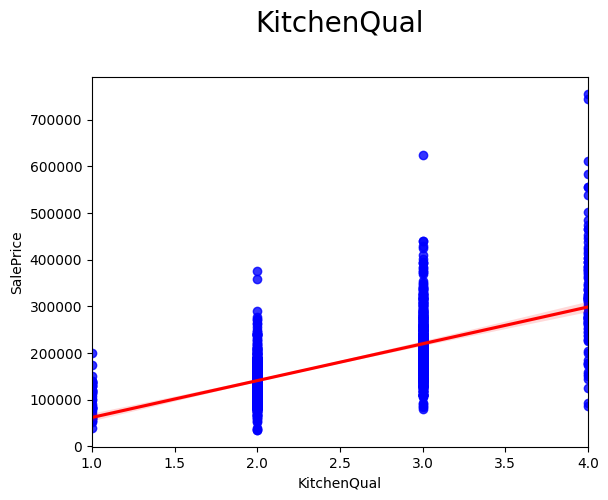

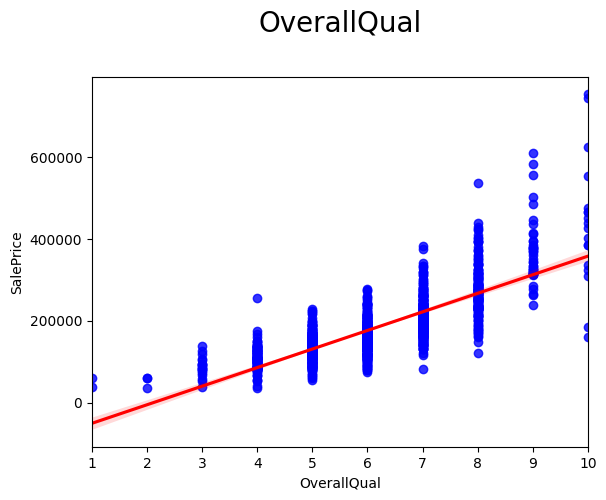

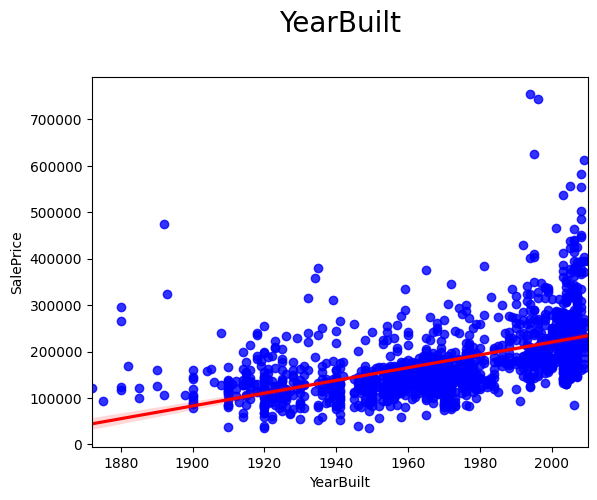

In [16]:
for col in vars_to_study:
    ax = sns.regplot(data=df, x=col, y="SalePrice", scatter_kws={"color": "blue"}, line_kws={"color": "red"})
    plt.ylabel('SalePrice')
    plt.xlabel(col)
    plt.title(f"{col}", fontsize=20, y=1.1)
    plt.show()

---

# Conclusions

* Overall quality has the higest impact on SalePrice
* Kitchen quality also impacts SalePrice with higher quality getting a higher price
* Newer homes have higher SalePrice
* Larger garage and living areas have higher SalePrice - a larger living area has the most impact 